# Librairies

In [1]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pylab as plt
import numpy as np
import zipfile
from tqdm import tqdm
import os

# Load Traffic Data

In [2]:
os.listdir('raw/')

['ds2710_ingressi_areac_2024_01.zip',
 'ds2726_ingressi_areac_2024_02.zip',
 'ds2730_ingressi_areac_2024_03.zip',
 'ds2793_ingressi_areac_2024_04.zip',
 'ds2794_ingressi_areac_2024_05.zip',
 'ds2801_ingressi_areac_2024_06.zip',
 'ds2825_ingressi_areac_2024_07.zip',
 'ds2826_ingressi_areac_2024_08.zip',
 'ds2850_ingressi_areac_2024_09.zip',
 'ingressi_areac_varchi_shp']

In [3]:
# Open the gzip-compressed file
l_df = []

for filename in tqdm(os.listdir('raw/')):
    
    if filename[-4:] == '.zip':
    
        month = filename[-6:-4]
        filename2 = f'ingressi_areac_2024_{month}'

        with zipfile.ZipFile(f'raw/{filename}', 'r') as z:
            with z.open(filename2 + '.csv') as f :
                l_df.append(pd.read_csv(f))
df = pd.concat(l_df)
l_df = None
            

100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


In [4]:
df.columns

Index(['dataora', 'id_varco', 'esenti', 'moto', 'residenti',
       'veicoli_servizio', 'categoria_euro', 'tipologia_alimentazione',
       'categoria_veicolo', 'classe_areac', 'fap', 'areac', 'numero_transiti'],
      dtype='object')

In [5]:
df.columns = [
    'datetime', 'checkpoint_id', 'exempt', 'motorcycles', 'residents',
    'service_vehicles', 'euro_category', 'fuel_type', 
    'vehicle_category', 'areac_class', 'particle_filter', 'areac_zone', 
    'number_of_transits'
]

In [6]:
df.datetime = pd.to_datetime(df.datetime.apply(lambda x : x[:-3]), format = '%Y-%m-%d %H:%M:%S', utc = False)
#df.datetime = pd.to_datetime(df.datetime).dt.tz_localize(None)

In [7]:
df.checkpoint_id.unique().size

40

In [8]:
# 30min frequency
df.datetime.unique()

<DatetimeArray>
['2024-01-01 00:00:00', '2024-01-01 00:30:00', '2024-01-01 01:00:00',
 '2024-01-01 01:30:00', '2024-01-01 02:00:00', '2024-01-01 02:30:00',
 '2024-01-01 03:00:00', '2024-01-01 03:30:00', '2024-01-01 04:00:00',
 '2024-01-01 04:30:00',
 ...
 '2024-09-30 19:00:00', '2024-09-30 19:30:00', '2024-09-30 20:00:00',
 '2024-09-30 20:30:00', '2024-09-30 21:00:00', '2024-09-30 21:30:00',
 '2024-09-30 22:00:00', '2024-09-30 22:30:00', '2024-09-30 23:00:00',
 '2024-09-30 23:30:00']
Length: 13150, dtype: datetime64[ns]

In [9]:
df[((df.datetime == '2024-01-01 02:00:00') | (df.datetime == '2024-01-01 02:30:00') )& (df.checkpoint_id == 57)].number_of_transits.sum()

73

In [10]:
# resample it to hourly 
# We have no metadata to interpret the other columns
df = df.set_index(['checkpoint_id', 'datetime'])[['number_of_transits']].groupby("checkpoint_id").resample("h", level="datetime").sum()

In [11]:
df

number_of_transits
checkpoint_id datetime                               
57            2024-01-01 00:00:00                  45
              2024-01-01 01:00:00                  96
              2024-01-01 02:00:00                  73
              2024-01-01 03:00:00                  46
              2024-01-01 04:00:00                  26
...                                               ...
98            2024-09-30 19:00:00                 365
              2024-09-30 20:00:00                 292
              2024-09-30 21:00:00                 163
              2024-09-30 22:00:00                 159
              2024-09-30 23:00:00                 143

[263040 rows x 1 columns]

In [12]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from temporal_agg import hourly_to_aadt

In [13]:
df = hourly_to_aadt(df, 'checkpoint_id', 'datetime', ['number_of_transits'])

In [14]:
df.columns = ['AADT', 'AAWT']

In [15]:
df.index.name = 'id_amat'
df

,AADT,AAWT
id_amat,,
57,4221.368613,4531.392857
58,5305.109489,5629.275510
59,961.127737,1002.428571
60,3035.032847,3132.653061
61,518.000000,542.724490
62,245.463504,246.280612
63,2556.094891,2750.188776
64,9603.583942,10411.775510
65,8027.777372,8467.520408


# Geographical reference

In [16]:
ref = gpd.read_file('raw/ingressi_areac_varchi_shp/ingressi_areac_varchi.shp')

In [17]:
ref.id_amat.unique()

array([57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90,
       91, 92, 93, 94, 95, 96, 97, 98])

In [18]:
ref.columns

Index(['id_amat', 'label', 'geometry'], dtype='object')

In [19]:
ref.rename(columns = {'label':'raw_name'}, inplace=True)

In [20]:
jf = ref.set_index('id_amat').join(
    df,
    how = 'inner'
)

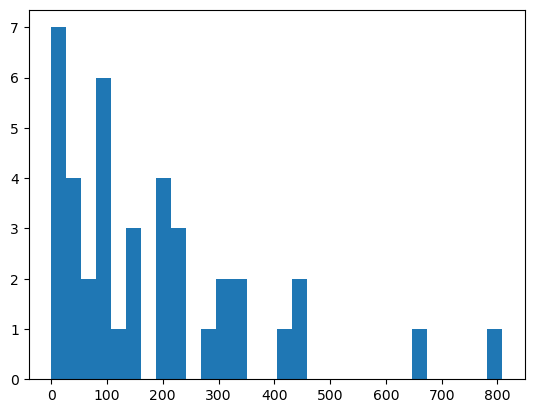

In [21]:
plt.hist(jf.AAWT - jf.AADT, bins = 30)
plt.show()

# Map matching with OSM

In [22]:
from map_matching_OSM import points_matching

In [23]:
jf = points_matching(jf)

City downloaded


100%|██████████| 40/40 [00:00<00:00, 212.26it/s]

We failed to match 0 sensors
...on a total of 40 sensors


In [24]:
jf[['raw_name', 'osm_name']]

,raw_name,osm_name
id_amat,,
57,PORTA TENAGLIA,Via di Porta Tenaglia
58,LEGNANO,Via Legnano
59,MOSCOVA,Piazzale Biancamano
60,VOLTA,Via Alessandro Volta
61,GARIBALDI,Corso Giuseppe Garibaldi
62,MILAZZO,Via Milazzo
63,CASTELFIDARDO,Via Castelfidardo
64,TURATI,Piazza della Repubblica
65,VENEZIA,Corso Venezia


# Final saving

In [27]:
jf[['AADT', 'AAWT', 'geometry', 'raw_name', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osmid']].to_file(f'treated/Milan_AADT_AAWT_2024.geojson', index=False)